# Setup

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from IPython.display import clear_output
from itertools import permutations

In [86]:
#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

In [87]:
data_processed = "../../data/processed/"
data_interim = "../../data/interim/"
data_external = "../../data/external/"

disgenet_edges = pd.read_csv(data_external+"curated_gene_disease_associations.tsv", sep="\t")
prime_edges = pd.read_csv(data_external+"primekg_edges.csv")
prime_nodes = pd.read_csv(data_external+"primekg_nodes.csv")
hippie = pd.read_csv(data_external + "hippie_current.txt",sep="\t", header=None).rename(columns={0:"x_name",1:"x_id",2:"y_name",3:"y_id",4:"score"}).drop(columns=5)
signor = pd.read_csv(data_interim + "signor_mapped.csv")

# disease_mappings = pd.read_csv(data_interim+"disease_vocab_mapping.csv")
# manual_maps = pd.read_csv(data_interim+"manual_disease_maps.csv")
disease_mappings = pd.read_csv(data_processed+"graph_data/disease_mappings.csv").drop(columns=["Unnamed: 0"])
prime_grouped_bert = pd.read_csv(data_external + "kg_grouped_diseases_bert_map.csv")

/tmp/ipykernel_45762/213346974.py:9: DtypeWarning: Columns (18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  signor = pd.read_csv(data_interim + "signor_mapped.csv")


In [88]:
# disgenet_merged = pd.merge(disgenet_edges,disease_mappings[["diseaseId","code","group_name_bert","group_id_bert","node_index"]],left_on="diseaseId",right_on="diseaseId", how="left").rename(columns={"code":"mondo_id","node_index":"prime_node_index"})

In [89]:
disgenet_merged = pd.merge(disgenet_edges,disease_mappings[["diseaseId","mondo_id","group_name_bert","group_id_bert","prime_node_index"]],left_on="diseaseId",right_on="diseaseId", how="left")

In [90]:
graph_node_data = {"node_id":{},"node_name":{},"node_type":{},"node_source":{}}
graph_edge_data = {"x_index":{},"y_index":{},"x_id":{},"y_id":{},"x_type":{},"y_type":{},"relation":{},"edge_source":{}}

# Stats antes de mergear

In [91]:
def quick_venn(item_list,set_names=None):
    plt.figure()
    venn_length = len(item_list)
    if venn_length == 2:
        s1 = set(item_list[0])
        s2 = set(item_list[1])
        v = venn2([s1,s2],set_names)
    if venn_length == 3:
        s1 = set(item_list[0])
        s2 = set(item_list[1])
        s3 = set(item_list[2])
        v = venn3([s1,s2,s3],set_names)


In [92]:
disgenet_gene_ids = disgenet_edges.geneId.unique()
disgenet_disease_ids = disgenet_edges.diseaseId.unique()

hippie_ids = list(set(np.concatenate([hippie["x_id"].unique(), hippie["y_id"].unique()])))

prime_ids = prime_nodes[prime_nodes.node_type == "disease"]["node_id"].values

signor_protein_ids = list(set(np.concatenate([signor[(signor.TYPEA == "protein") & (signor.TYPEB == "protein")]["ENTREZ_ID_A"].values ,signor[(signor.TYPEA == "protein") & (signor.TYPEB == "protein")]["ENTREZ_ID_B"].values, signor[(signor.TYPEA == "protein") & (signor.TYPEB == "complex") & (signor.EFFECT == "form complex")]["ENTREZ_ID_A"]])))
signor_complex_ids = list(set(np.concatenate([signor[(signor.TYPEA == "protein") & (signor.TYPEB == "complex") & (signor.EFFECT == "form complex")]["IDB"]])))

In [93]:
disgenet_stats = {"num_nodos":len(disgenet_disease_ids) + len(disgenet_gene_ids), "num_enlaces":len(disgenet_edges), "num_enfermedades":len(disgenet_disease_ids),"num_genes":len(disgenet_gene_ids)}
primekg_stats = {"num_nodos":len(prime_ids), "num_enlaces":len(prime_edges[prime_edges.relation == "disease_disease"]),"num_enfermedades":len(prime_ids),"num_genes":0}
hippie_stats = {"num_nodos":len(hippie_ids),"num_enlaces":len(hippie),"num_enfermedades":0,"num_genes":len(hippie_ids)}
signor_stats = {"num_nodos":len(signor_protein_ids)+len(signor_complex_ids), "num_enlaces":len(signor[(signor.TYPEA == "protein") & (signor.TYPEB == "protein")]) + len(signor[(signor.TYPEA == "protein") & (signor.TYPEB == "complex") & (signor.EFFECT == "form complex")]), "num_enfermedades":0,"num_genes":len(signor_protein_ids)}

display(pd.DataFrame.from_dict({"disgenet":disgenet_stats,"prime":primekg_stats,"hippie":hippie_stats,"signor":signor_stats}))

,disgenet,prime,hippie,signor
num_nodos,20884,17080,19679,6915
num_enlaces,84038,64388,831933,23835
num_enfermedades,11181,17080,0,0
num_genes,9703,0,19679,6493


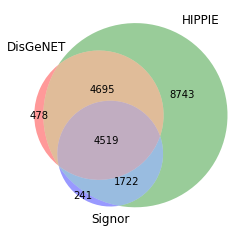

In [94]:
set_disgenet_genes = set(disgenet_gene_ids)
set_hippie_genes = set(hippie_ids)
set_signor_genes = set(signor_protein_ids)

plt.figure()
v1 = venn3([set_disgenet_genes,set_hippie_genes,set_signor_genes], set_labels = ["DisGeNET","HIPPIE","Signor"])

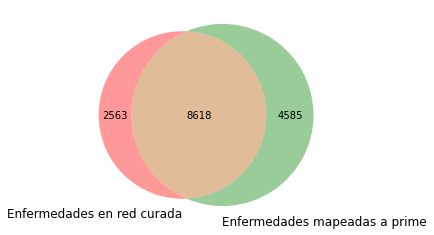

In [95]:
node_indexes = disease_mappings.prime_node_index.unique()
disease_ids = disease_mappings.diseaseId.unique()

map_ids = disease_mappings.diseaseId.unique()
edge_ids = disgenet_disease_ids

plt.figure()
v = venn2([set(edge_ids),set(map_ids)],["Enfermedades en red curada","Enfermedades mapeadas a prime"])

nodos_compartidos = set(map_ids)&set(edge_ids)

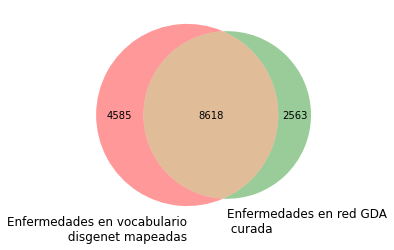

In [96]:
s1 = set(disease_mappings.diseaseId.unique())
s2 = set(disgenet_disease_ids)

plt.figure()
v = venn2([s1,s2],["Enfermedades en vocabulario\n disgenet mapeadas", "Enfermedades en red GDA\n curada"])

all_diseases_in_dgn_vocabulary = s1|s2

# Armo capa de enfermedades

Estos son todos los enlaces que tengo en Prime Knowledge Base involucrando a enfermedades de DisGeNET!

In [97]:
prime_edges.set_index("x_index").loc[node_indexes].relation.value_counts()

disease_phenotype_positive    110651
disease_protein                68197
disease_disease                33870
contraindication               26650
indication                      8018
exposure_disease                2263
off-label use                   2160
disease_phenotype_negative       944
Name: relation, dtype: int64

In [98]:
enlaces_disease_disease = prime_edges.set_index("y_index").loc[node_indexes].reset_index()
enlaces_disease_disease = enlaces_disease_disease[enlaces_disease_disease.relation == "disease_disease"]
enlaces_disease_disease = enlaces_disease_disease.set_index("x_index").loc[enlaces_disease_disease.set_index("x_index").index.intersection(node_indexes)].reset_index()

In [99]:
enlaces_disease_disease

,x_index,y_index,relation,display_relation
0,38497,31820,disease_disease,parent-child
1,38497,29089,disease_disease,parent-child
2,38500,31820,disease_disease,parent-child
3,38500,33610,disease_disease,parent-child
4,38500,30905,disease_disease,parent-child
...,...,...,...,...
18111,29937,38327,disease_disease,parent-child
18112,39648,36205,disease_disease,parent-child
18113,36565,36205,disease_disease,parent-child
18114,28729,32248,disease_disease,parent-child


In [100]:
disease_mappings

,diseaseId,name,mondo_id,vocabularyName,group_name_auto,group_name_bert,group_id_bert,prime_node_index
0,C0000744,Abetalipoproteinemia,8692,abetalipoproteinemia,NaN,NaN,NaN,31820
1,C0000768,Congenital Abnormality,839,congenital abnormality,NaN,NaN,NaN,35598
2,C0000771,"Abnormalities, Drug-Induced",16677,toxic or drug-related embryofetopathy,NaN,NaN,NaN,38626
3,C0000809,"Abortion, Habitual",6774,habitual spontaneous abortion,NaN,NaN,NaN,95075
4,C0000821,Threatened abortion,4846,placental abruption (disease),NaN,NaN,NaN,83943
...,...,...,...,...,...,...,...,...
13198,C0334492,Malignant mesenchymal tumor,3633,malignant mesenchymoma,NaN,NaN,NaN,37185
13199,C0037999,Splenic Neoplasms,36696,spleen neoplasm,NaN,NaN,NaN,37880
13200,C1866559,"Spina Bifida, Folate-Sensitive",11120,"neural tube defects, folate-sensitive",NaN,NaN,NaN,28904
13201,C1406717,Sirenomelia syndrome,8800,microphthalmia with limb anomalies,NaN,NaN,NaN,27616


Esto daba una cantidad desorbitante de enlaces, creo que es porque se están multiplicando muchos nodos de grado alto

In [101]:
# enlaces_dd_mapeados = pd.merge(enlaces_disease_disease,disease_mappings[["code","diseaseId","node_index"]],left_on="x_index",right_on="node_index",how="left").drop(columns=["node_index"]).rename(columns={"code":"x_mondo_id","diseaseId":"x_id"})
# enlaces_dd_mapeados = pd.merge(enlaces_dd_mapeados,disease_mappings[["code","diseaseId","node_index"]],left_on="y_index",right_on="node_index",how="left").drop(columns=["node_index"]).rename(columns={"code":"y_mondo_id","diseaseId":"y_id"})

In [102]:
disease_mappings[disease_mappings.prime_node_index.duplicated(keep=False)].sort_values(by="prime_node_index")

,diseaseId,name,mondo_id,vocabularyName,group_name_auto,group_name_bert,group_id_bert,prime_node_index
7178,C1970458,"Osteogenesis imperfecta, type VIII",12581,osteogenesis imperfecta type 8,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
10648,C4746956,"OSTEOGENESIS IMPERFECTA, TYPE XIX",49223,"osteogenesis imperfecta, type 19",osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
8731,C3553887,"OSTEOGENESIS IMPERFECTA, TYPE XIII",13924,osteogenesis imperfecta type 13,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
8344,C3279564,"Osteogenesis Imperfecta, Type VI",13515,osteogenesis imperfecta type 6,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
11138,C0023931,Lobstein Disease,8146,osteogenesis imperfecta type 1,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
...,...,...,...,...,...,...,...,...
3039,C0268800,Simple renal cyst,44113,bullous systemic lupus erythematosus,NaN,NaN,NaN,99864
11024,C0236800,Panic disorder with agoraphobia,44141,panic disorder without agoraphobia,panic disorder without agoraphobia,panic disorder without or with agoraphobia,44141_44144,99866
11931,C0236794,Panic disorder without agoraphobia,44141,panic disorder without agoraphobia,panic disorder without agoraphobia,panic disorder without or with agoraphobia,44141_44144,99866
9237,C3888203,SPRINTING PERFORMANCE,60593,actn3 deficiency,NaN,NaN,NaN,99951


### Separo nodos bert

Estos nodos no se van a "transformar" en el nodo bert, sino que los conservo como nodos sueltos y los enlazo a nodos grupo bert que voy a agregar.

In [103]:
bert_mask = disease_mappings.group_id_bert.isna()
mapa_nodos_bert = disease_mappings[~bert_mask]
mapa_nodos_no_bert = disease_mappings[bert_mask]
mapa_nodos_bert.sort_values(by="prime_node_index")

,diseaseId,name,mondo_id,vocabularyName,group_name_auto,group_name_bert,group_id_bert,prime_node_index
8797,C3554428,"OSTEOGENESIS IMPERFECTA, TYPE XIV",14029,osteogenesis imperfecta type 14,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
9709,C4225301,"OSTEOGENESIS IMPERFECTA, TYPE XVII",14672,osteogenesis imperfecta type 17,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
2956,C0268363,Osteogenesis imperfecta type IV (disorder),8148,osteogenesis imperfecta type 4,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
10648,C4746956,"OSTEOGENESIS IMPERFECTA, TYPE XIX",49223,"osteogenesis imperfecta, type 19",osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
2955,C0268362,Osteogenesis imperfecta type III (disorder),9804,osteogenesis imperfecta type 3,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...,27158
...,...,...,...,...,...,...,...,...
5534,C1832526,"CATARACT, NONNUCLEAR POLYMORPHIC CONGENITAL, A...",22673,autosomal dominant non-nuclear cataract,autosomal dominant non-nuclear cataract,autosomal dominant cataract,22672_22673,99220
3209,C0279084,Kaposi's sarcoma classical type,22772,classic Kaposi sarcoma,classic Kaposi sarcoma,Kaposi sarcoma,22772_23067,99253
11931,C0236794,Panic disorder without agoraphobia,44141,panic disorder without agoraphobia,panic disorder without agoraphobia,panic disorder without or with agoraphobia,44141_44144,99866
11024,C0236800,Panic disorder with agoraphobia,44141,panic disorder without agoraphobia,panic disorder without agoraphobia,panic disorder without or with agoraphobia,44141_44144,99866


Genero los nodos bert y sus enlaces

In [104]:
nodos_bert = mapa_nodos_bert[["group_id_bert","group_name_bert","prime_node_index"]].drop_duplicates(subset="group_id_bert").reset_index(drop=True)
enlaces_bert_disgenet = mapa_nodos_bert[["diseaseId","group_id_bert"]].drop_duplicates().reset_index(drop=True)

bert_node_data = nodos_bert.rename(columns={"group_id_bert":"node_id","group_name_bert":"node_name"})
bert_node_data["node_type"] = "bert_group"
bert_node_data["node_source"] = "primekg"

bert_edge_data = enlaces_bert_disgenet.rename(columns={"diseaseId":"x_id","group_id_bert":"y_id"})
bert_edge_data["relation"] = "disease_disease"
bert_edge_data["x_type"] = "disease"
bert_edge_data["y_type"] = "bert_group"
bert_edge_data["edge_source"] = "primekg"

bert_edge_data

,x_id,y_id,relation,x_type,y_type,edge_source
0,C0001079,8702_10966_8701_19648,disease_disease,disease,bert_group,primekg
1,C0001126,8369_11422_9967_8368_15827_17828_1909_18440_17829,disease_disease,disease,bert_group,primekg
2,C0001249,6636_5630,disease_disease,disease,bert_group,primekg
3,C0001339,11986_4982_5003_6515_3232,disease_disease,disease,bert_group,primekg
4,C0001546,8187_2050_5618_5451_5371_100081_5383_1942_1098...,disease_disease,disease,bert_group,primekg
...,...,...,...,...,...,...
5001,C0342200,44331_16408_19858_18612_16410_15792_16409,disease_disease,disease,bert_group,primekg
5002,C0152264,54802_33483_12353_54801_12729,disease_disease,disease,bert_group,primekg
5003,C3161175,15193_18221,disease_disease,disease,bert_group,primekg
5004,C2931010,12123_54559_8909_26765_14904_11291_26729_30043...,disease_disease,disease,bert_group,primekg


In [105]:
single_disease_node_data = mapa_nodos_no_bert[["diseaseId","name","prime_node_index"]].rename(columns={"diseaseId":"node_id","name":"node_name"}).reset_index(drop=True)
single_disease_node_data["node_type"] = "disease"
single_disease_node_data["node_source"] = "disgenet"

single_disease_node_data

,node_id,node_name,prime_node_index,node_type,node_source
0,C0000744,Abetalipoproteinemia,31820,disease,disgenet
1,C0000768,Congenital Abnormality,35598,disease,disgenet
2,C0000771,"Abnormalities, Drug-Induced",38626,disease,disgenet
3,C0000809,"Abortion, Habitual",95075,disease,disgenet
4,C0000821,Threatened abortion,83943,disease,disgenet
...,...,...,...,...,...
8192,C0334492,Malignant mesenchymal tumor,37185,disease,disgenet
8193,C0037999,Splenic Neoplasms,37880,disease,disgenet
8194,C1866559,"Spina Bifida, Folate-Sensitive",28904,disease,disgenet
8195,C1406717,Sirenomelia syndrome,27616,disease,disgenet


In [106]:
bert_disease_data = mapa_nodos_bert[["diseaseId","name"]].rename(columns={"diseaseId":"node_id","name":"node_name"}).reset_index(drop=True).drop_duplicates()
bert_disease_data["node_type"] = "disease"
bert_disease_data["node_source"] = "disgenet"
bert_disease_data

,node_id,node_name,node_type,node_source
0,C0001079,Achondrogenesis,disease,disgenet
1,C0001126,Renal tubular acidosis,disease,disgenet
2,C0001249,Actinobacillus Infections,disease,disgenet
3,C0001339,Acute pancreatitis,disease,disgenet
4,C0001546,Adjustment Disorders,disease,disgenet
...,...,...,...,...
5001,C0342200,Endemic Cretinism,disease,disgenet
5002,C0152264,Familial erythrocytosis,disease,disgenet
5003,C3161175,Hydrops fetalis due to alpha thalassemia,disease,disgenet
5004,C2931010,Congenital disorder of glycosylation type 2E,disease,disgenet


In [107]:
disease_layer_nodes = pd.concat([bert_node_data,single_disease_node_data,bert_disease_data])
disease_layer_nodes

,node_id,node_name,prime_node_index,node_type,node_source
0,8702_10966_8701_19648,achondrogenesis,27350.0,bert_group,primekg
1,8369_11422_9967_8368_15827_17828_1909_18440_17829,renal tubular acidosis,27478.0,bert_group,primekg
2,6636_5630,Actinobacillus infectious disease,97104.0,bert_group,primekg
3,11986_4982_5003_6515_3232,pancreatitis,31493.0,bert_group,primekg
4,8187_2050_5618_5451_5371_100081_5383_1942_1098...,anxiety disorder,27933.0,bert_group,primekg
...,...,...,...,...,...
5001,C0342200,Endemic Cretinism,NaN,disease,disgenet
5002,C0152264,Familial erythrocytosis,NaN,disease,disgenet
5003,C3161175,Hydrops fetalis due to alpha thalassemia,NaN,disease,disgenet
5004,C2931010,Congenital disorder of glycosylation type 2E,NaN,disease,disgenet


In [108]:
disease_layer_nodes.node_id.duplicated().value_counts()

False    14270
Name: node_id, dtype: int64

<AxesSubplot:>

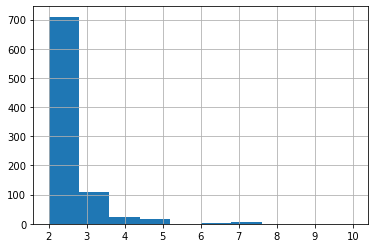

In [109]:
mask = ~disease_layer_nodes.prime_node_index.isna() & disease_layer_nodes.prime_node_index.duplicated(keep=False)
repeticiones = disease_layer_nodes[mask].prime_node_index.value_counts()
repeticiones.hist()

In [110]:
disease_layer_edges = pd.merge(enlaces_disease_disease,disease_layer_nodes,left_on="x_index",right_on="prime_node_index").drop(columns=["prime_node_index","node_source","node_name"]).rename(columns={"node_id":"x_id","node_name":"x_name","node_type":"x_type"})
disease_layer_edges  = pd.merge(disease_layer_edges ,disease_layer_nodes,left_on="y_index",right_on="prime_node_index").drop(columns=["prime_node_index","node_source","node_name","x_index","y_index","display_relation"]).rename(columns={"node_id":"y_id","node_name":"y_name","node_type":"y_type"})
disease_layer_edges

,relation,x_id,x_type,y_id,y_type
0,disease_disease,C0687751,disease,C0000744,disease
1,disease_disease,C0020597,disease,C0000744,disease
2,disease_disease,C0687751,disease,C0398568,disease
3,disease_disease,C0020597,disease,C0020623,disease
4,disease_disease,C0023772,disease,C0020623,disease
...,...,...,...,...,...
24959,disease_disease,C1849821,disease,C0268194,disease
24960,disease_disease,8652_17546_17547,bert_group,C0206762,disease
24961,disease_disease,C4310632,disease,C1849508,disease
24962,disease_disease,C0020514,disease,C0008043,disease


In [111]:
enlaces_bert_disgenet["relation"] = "disease_disease"
enlaces_bert_disgenet["y_type"] = "bert_group"
enlaces_bert_disgenet["x_type"] = "disease"
enlaces_bert_disgenet = enlaces_bert_disgenet.rename(columns={"diseaseId":"x_id","group_id_bert":"y_id"})

disease_layer_edges = pd.concat([disease_layer_edges,enlaces_bert_disgenet])
disease_layer_edges["edge_source"] = "primekg"

disease_layer_edges

,relation,x_id,x_type,y_id,y_type,edge_source
0,disease_disease,C0687751,disease,C0000744,disease,primekg
1,disease_disease,C0020597,disease,C0000744,disease,primekg
2,disease_disease,C0687751,disease,C0398568,disease,primekg
3,disease_disease,C0020597,disease,C0020623,disease,primekg
4,disease_disease,C0023772,disease,C0020623,disease,primekg
...,...,...,...,...,...,...
5001,disease_disease,C0342200,disease,44331_16408_19858_18612_16410_15792_16409,bert_group,primekg
5002,disease_disease,C0152264,disease,54802_33483_12353_54801_12729,bert_group,primekg
5003,disease_disease,C3161175,disease,15193_18221,bert_group,primekg
5004,disease_disease,C2931010,disease,12123_54559_8909_26765_14904_11291_26729_30043...,bert_group,primekg


In [112]:
disease_layer_nodes

,node_id,node_name,prime_node_index,node_type,node_source
0,8702_10966_8701_19648,achondrogenesis,27350.0,bert_group,primekg
1,8369_11422_9967_8368_15827_17828_1909_18440_17829,renal tubular acidosis,27478.0,bert_group,primekg
2,6636_5630,Actinobacillus infectious disease,97104.0,bert_group,primekg
3,11986_4982_5003_6515_3232,pancreatitis,31493.0,bert_group,primekg
4,8187_2050_5618_5451_5371_100081_5383_1942_1098...,anxiety disorder,27933.0,bert_group,primekg
...,...,...,...,...,...
5001,C0342200,Endemic Cretinism,NaN,disease,disgenet
5002,C0152264,Familial erythrocytosis,NaN,disease,disgenet
5003,C3161175,Hydrops fetalis due to alpha thalassemia,NaN,disease,disgenet
5004,C2931010,Congenital disorder of glycosylation type 2E,NaN,disease,disgenet


# Armo la red GDA

In [113]:
column_pairs = [("x_id","y_id"),("x_type","y_type")]

def make_undirected(df,column_pairs):
    new_combinations = [item for sublist in [list(permutations(column_pair,2)) for column_pair in column_pairs] for item in sublist]
    reversed_columns = {old:new for (old,new) in new_combinations}
    reversed_dataframe = df.rename(columns=reversed_columns)
    df = pd.concat([df,reversed_dataframe]).drop_duplicates()
    return df

In [114]:
gda_disease_data = disgenet_edges[["diseaseId","diseaseName"]].rename(columns={"diseaseId":"node_id","diseaseName":"node_name"}).drop_duplicates()
gda_disease_data["node_type"] = "disease"
gda_disease_data["node_source"] = "disgenet"

gda_gene_data = disgenet_edges[["geneId","geneSymbol"]].rename(columns={"geneId":"node_id","geneSymbol":"node_name"}).drop_duplicates()
gda_gene_data["node_type"] = "gene_protein"
gda_gene_data["node_source"] = "disgenet"

gda_node_data = pd.concat([gda_disease_data,gda_gene_data])
gda_node_data

,node_id,node_name,node_type,node_source
0,C0019209,Hepatomegaly,disease,disgenet
1,C0036341,Schizophrenia,disease,disgenet
2,C0002395,Alzheimer's Disease,disease,disgenet
3,C0007102,Malignant tumor of colon,disease,disgenet
4,C0009375,Colonic Neoplasms,disease,disgenet
...,...,...,...,...
84028,106481323,RNU6-456P,gene_protein,disgenet
84030,106783499,OPA8,gene_protein,disgenet
84031,107075310,MTCO2P12,gene_protein,disgenet
84032,107305681,DHS6S1,gene_protein,disgenet


In [115]:
gda_edge_data = disgenet_edges[["geneId","diseaseId"]].rename(columns={"geneId":"x_id","diseaseId":"y_id"})
gda_edge_data["relation"] = "gda"
gda_edge_data["x_type"] = "gene_protein"
gda_edge_data["y_type"] = "disease"
gda_edge_data["edge_source"] = "disgenet"
gda_edge_data["edge_source_index"] = disgenet_edges.index
gda_edge_data

,x_id,y_id,relation,x_type,y_type,edge_source,edge_source_index
0,1,C0019209,gda,gene_protein,disease,disgenet,0
1,1,C0036341,gda,gene_protein,disease,disgenet,1
2,2,C0002395,gda,gene_protein,disease,disgenet,2
3,2,C0007102,gda,gene_protein,disease,disgenet,3
4,2,C0009375,gda,gene_protein,disease,disgenet,4
...,...,...,...,...,...,...,...
84033,109580095,C0002875,gda,gene_protein,disease,disgenet,84033
84034,109580095,C0005283,gda,gene_protein,disease,disgenet,84034
84035,109580095,C0019025,gda,gene_protein,disease,disgenet,84035
84036,109580095,C0085578,gda,gene_protein,disease,disgenet,84036


# Armo la red PPI

## Hippie

In [116]:
def reversed_dict(column_pairs):
    new_combinations = [item for sublist in [list(permutations(column_pair,2)) for column_pair in column_pairs] for item in sublist]
    reversed_columns = {old:new for (old,new) in new_combinations}
    return reversed_columns

Preprocesado:

Saco los "_HUMAN" de los nombres de genes y filtro por score de evidencia mayor a 0.73, que es el umbral de high confidence para hippie.

Saco self-loops

Filtro nans en ints y en texto

In [117]:
hippie = hippie.dropna()
hippie = hippie[hippie.score > 0.73]
hippie.x_name = hippie.x_name.apply(lambda x: str(x).split("_")[0])
hippie.y_name = hippie.y_name.apply(lambda x: str(x).split("_")[0])
hippie = hippie[hippie.x_id != hippie.y_id]
hippie

,x_name,x_id,y_name,y_id,score
4,GRB7,2886,ERBB2,2064,0.90
6,DLG4,1742,ERBB2,2064,0.88
7,P85B,5296,ERBB2,2064,0.90
8,PTN18,26469,ERBB2,2064,0.88
9,LAP2,55914,ERBB2,2064,0.97
...,...,...,...,...,...
831669,TRI37,4591,DCD,117159,0.82
831670,RHOB,388,RFIP1,80223,0.82
831774,ARL8B,55207,INP5K,51763,0.75
831795,PHB,5245,ODPA,5160,0.82


In [118]:
hippie_node_data = pd.concat([hippie[["x_name","x_id"]].rename(columns={"x_name":"node_name","x_id":"node_id"}), hippie[["y_name","y_id"]].rename(columns={"y_name":"node_name","y_id":"node_id"})]).drop_duplicates()
hippie_node_data["node_type"] = "gene_protein"
hippie_node_data["node_source"] = "hippie"

hippie_node_data

,node_name,node_id,node_type,node_source
4,GRB7,2886,gene_protein,hippie
6,DLG4,1742,gene_protein,hippie
7,P85B,5296,gene_protein,hippie
8,PTN18,26469,gene_protein,hippie
9,LAP2,55914,gene_protein,hippie
...,...,...,...,...
771576,GATCL,283459,gene_protein,hippie
791390,KAD3,50808,gene_protein,hippie
796911,F195B,348262,gene_protein,hippie
814144,SO4A1,28231,gene_protein,hippie


In [119]:
hippie_edge_data = hippie.drop(columns=["score","x_name","y_name"])
hippie_edge_data["edge_source_index"] = hippie.index
hippie_edge_data = hippie_edge_data.drop_duplicates(subset=["x_id","y_id"])
hippie_edge_data["relation"] = "ppi"
hippie_edge_data["edge_source"] = "hippie"
hippie_edge_data[["x_type","y_type"]] = "gene_protein"

In [120]:
hippie_edge_data

,x_id,y_id,edge_source_index,relation,edge_source,x_type,y_type
4,2886,2064,4,ppi,hippie,gene_protein,gene_protein
6,1742,2064,6,ppi,hippie,gene_protein,gene_protein
7,5296,2064,7,ppi,hippie,gene_protein,gene_protein
8,26469,2064,8,ppi,hippie,gene_protein,gene_protein
9,55914,2064,9,ppi,hippie,gene_protein,gene_protein
...,...,...,...,...,...,...,...
831669,4591,117159,831669,ppi,hippie,gene_protein,gene_protein
831670,388,80223,831670,ppi,hippie,gene_protein,gene_protein
831774,55207,51763,831774,ppi,hippie,gene_protein,gene_protein
831795,5245,5160,831795,ppi,hippie,gene_protein,gene_protein


# Pathways

In [121]:
protein_pathway_edges = prime_edges[prime_edges.relation == "pathway_protein"]

protein_pathway_nodes = pd.concat([protein_pathway_edges["x_index"].rename("node_index"), protein_pathway_edges["y_index"].rename("node_index")]).drop_duplicates()
protein_pathway_nodes = pd.merge(protein_pathway_nodes, prime_nodes, left_on="node_index", right_on="node_index").rename(columns={"node_index":"prime_node_index"})
protein_pathway_nodes.node_source = protein_pathway_nodes.node_source.apply(lambda x: "primekg_"+str(x))

protein_pathway_edges = pd.merge(protein_pathway_edges,protein_pathway_nodes[["prime_node_index","node_id","node_type"]],left_on="x_index",right_on="prime_node_index",how="left").rename(columns={"node_id":"x_id","node_type":"x_type"}).drop(columns=["prime_node_index","display_relation"])
protein_pathway_edges = pd.merge(protein_pathway_edges,protein_pathway_nodes[["prime_node_index","node_id","node_type"]],left_on="y_index",right_on="prime_node_index",how="left").rename(columns={"node_id":"y_id","node_type":"y_type"}).drop(columns=["prime_node_index"])

protein_pathway_edges = protein_pathway_edges.drop(columns=["x_index","y_index"])
protein_pathway_edges.x_type = protein_pathway_edges.x_type.apply(lambda x: str(x).replace("gene/protein", "gene_protein"))
protein_pathway_edges.y_type = protein_pathway_edges.y_type.apply(lambda x: str(x).replace("gene/protein", "gene_protein"))
protein_pathway_edges["edge_source"] = "primekg"


protein_pathway_nodes = protein_pathway_nodes.drop(columns=["prime_node_index"]).drop_duplicates()
protein_pathway_nodes.loc[protein_pathway_nodes.node_type == "gene/protein", "node_type"] = "gene_protein"
protein_pathway_nodes

,node_id,node_type,node_name,node_source
0,1,gene_protein,A1BG,primekg_NCBI
1,10,gene_protein,NAT2,primekg_NCBI
2,100,gene_protein,ADA,primekg_NCBI
3,1000,gene_protein,CDH2,primekg_NCBI
4,10000,gene_protein,AKT3,primekg_NCBI
...,...,...,...,...
12864,R-HSA-5579013,pathway,Defective CYP7B1 causes SPG5A and CBAS3,primekg_REACTOME
12865,R-HSA-5579007,pathway,Defective ACY1 causes encephalopathy,primekg_REACTOME
12866,R-HSA-4687000,pathway,Defective MPDU1 causes MPDU1-CDG (CDG-1f),primekg_REACTOME
12867,R-HSA-1855231,pathway,Synthesis of IPs in the ER lumen,primekg_REACTOME


In [122]:
protein_pathway_edges

,relation,x_id,x_type,y_id,y_type,edge_source
0,pathway_protein,1,gene_protein,R-HSA-114608,pathway,primekg
1,pathway_protein,1,gene_protein,R-HSA-6798695,pathway,primekg
2,pathway_protein,10,gene_protein,R-HSA-156582,pathway,primekg
3,pathway_protein,100,gene_protein,R-HSA-74217,pathway,primekg
4,pathway_protein,1000,gene_protein,R-HSA-381426,pathway,primekg
...,...,...,...,...,...,...
85287,pathway_protein,R-HSA-5576893,pathway,9992,gene_protein,primekg
85288,pathway_protein,R-HSA-3899300,pathway,9994,gene_protein,primekg
85289,pathway_protein,R-HSA-5628897,pathway,9997,gene_protein,primekg
85290,pathway_protein,R-HSA-611105,pathway,9997,gene_protein,primekg


Overlap de nodos gen en las redes: gda, ppi y pathway-protein

/home/ingrid/.local/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


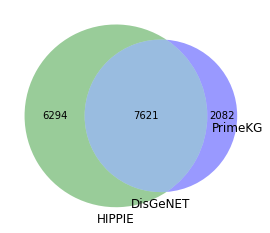

In [123]:
quick_venn([protein_pathway_nodes[protein_pathway_nodes.node_type == "gene/protein"].node_id.astype("int").values, hippie_node_data.node_id.values, gda_gene_data.node_id.values],["PrimeKG","HIPPIE","DisGeNET"])

# Complejos

signor_edges[TYPEA == "protein" & TYPEB == "complex" & EFFECT == "form complex", c("ENTREZ_ID_A","IDB","edge_index")]

In [124]:
signor["edge_source_index"] = signor.index
signor_complex_edges = signor[(signor.TYPEA == "protein") & (signor.TYPEB == "complex") & (signor.EFFECT == "form complex")][["ENTITYA","TYPEA","ENTITYB","TYPEB","IDB","ENTREZ_ID_A","edge_source_index"]].dropna().astype({"ENTREZ_ID_A":"int"}).drop_duplicates(subset=["ENTITYA","TYPEA","ENTITYB","TYPEB","IDB","ENTREZ_ID_A"])

signor_complex_edges = signor_complex_edges.rename(columns={"ENTITYA":"x_name","ENTITYB":"y_name","TYPEA":"x_type","TYPEB":"y_type","ENTREZ_ID_A":"x_id","IDB":"y_id"})
signor_complex_edges["edge_source"] = "signor"
signor_complex_edges["relation"] = "form_complex"
signor_complex_edges["x_type"] = "gene_protein"

signor_complex_edges = signor_complex_edges.drop_duplicates(subset=["x_id","y_id"])

signor_node_data = pd.concat([signor_complex_edges[["x_name","x_type","x_id"]].rename(columns = {"x_name":"node_name","x_type":"node_type","x_id":"node_id"}),signor_complex_edges[["y_name","y_type","y_id"]].rename(columns = {"y_name":"node_name","y_type":"node_type","y_id":"node_id"})]).drop_duplicates().dropna()
signor_node_data["node_source"] = "signor"

signor_complex_edges = signor_complex_edges.drop(columns=["x_name","y_name"])

signor_node_data

,node_name,node_type,node_id,node_source
8831,MSH2,gene_protein,4436,signor
18801,SIX1,gene_protein,6495,signor
19574,MAPK12,gene_protein,6300,signor
19699,CLTA,gene_protein,1211,signor
19717,HPS6,gene_protein,79803,signor
...,...,...,...,...
29647,HIRA complex 1,complex,SIGNOR-C461,signor
29650,HIRA complex 2,complex,SIGNOR-C462,signor
29668,ETF,complex,SIGNOR-C463,signor
29780,SL1 complex,complex,SIGNOR-C464,signor


In [125]:
signor_complex_edges

,x_type,y_type,y_id,x_id,edge_source_index,edge_source,relation
8831,gene_protein,complex,SIGNOR-C60,4436,8831,signor,form_complex
18801,gene_protein,complex,SIGNOR-C122,6495,18801,signor,form_complex
19574,gene_protein,complex,SIGNOR-C218,6300,19574,signor,form_complex
19699,gene_protein,complex,SIGNOR-C249,1211,19699,signor,form_complex
19717,gene_protein,complex,SIGNOR-C252,79803,19717,signor,form_complex
...,...,...,...,...,...,...,...
29807,gene_protein,complex,SIGNOR-C465,2648,29807,signor,form_complex
29808,gene_protein,complex,SIGNOR-C465,8295,29808,signor,form_complex
29809,gene_protein,complex,SIGNOR-C465,8464,29809,signor,form_complex
29810,gene_protein,complex,SIGNOR-C465,9015,29810,signor,form_complex


# Uno todas las redes

In [126]:
edge_data = {"gda":gda_edge_data, "ppi":hippie_edge_data,"pathways":protein_pathway_edges,"complex":signor_complex_edges,"diseases":disease_layer_edges}
node_data = {"gda":gda_node_data, "ppi":hippie_node_data, "pathways":protein_pathway_nodes, "complex":signor_node_data,"diseases":disease_layer_nodes.drop(columns="prime_node_index")}

In [127]:
merged_edges = pd.concat([edges.astype("string") for edges in edge_data.values()]).sort_values(by="edge_source").drop_duplicates(subset=["x_id","y_id","relation","x_type","y_type","edge_source"])
merged_edges = make_undirected(merged_edges,[("x_id","y_id"),("x_type","y_type")]).sort_values(by="edge_source").drop_duplicates(subset=["x_id","y_id","relation","x_type","y_type","edge_source"]).sort_values(by="x_id").reset_index(drop=True)

In [128]:
merged_edges

,x_id,y_id,relation,x_type,y_type,edge_source,edge_source_index
0,1,C0019209,gda,gene_protein,disease,disgenet,0
1,1,R-HSA-114608,pathway_protein,gene_protein,pathway,primekg,<NA>
2,1,10422,ppi,gene_protein,gene_protein,hippie,357083
3,1,63891,ppi,gene_protein,gene_protein,hippie,358639
4,1,284403,ppi,gene_protein,gene_protein,hippie,297494
...,...,...,...,...,...,...,...
512239,SIGNOR-C97,3516,form_complex,complex,gene_protein,signor,22429
512240,SIGNOR-C98,51107,form_complex,complex,gene_protein,signor,25191
512241,SIGNOR-C98,23385,form_complex,complex,gene_protein,signor,25190
512242,SIGNOR-C98,5663,form_complex,complex,gene_protein,signor,22440


In [129]:
len(merged_edges)/2

256122.0

In [130]:
merged_edges.relation.value_counts()/2

ppi                110062.0
gda                 84038.0
pathway_protein     42646.0
disease_disease     17488.0
form_complex         1888.0
Name: relation, dtype: Float64

In [131]:
merged_nodes = pd.concat([nodes.astype("string") for nodes in node_data.values()]).sort_values(by="node_source").drop_duplicates()
merged_nodes = merged_nodes.sort_values(by="node_source").drop_duplicates(subset="node_id",keep="first")
merged_nodes.node_type.value_counts()

gene_protein    17363
disease         15766
pathway          2020
bert_group       1067
complex           422
Name: node_type, dtype: Int64

Agrego identificadores de nodos y enlaces

In [132]:
merged_nodes = merged_nodes.sort_values(by="node_id").reset_index(drop=True)
merged_nodes["node_index"] = merged_nodes.index
merged_nodes

,node_id,node_name,node_type,node_source,node_index
0,1,A1BG,gene_protein,disgenet,0
1,10,NAT2,gene_protein,disgenet,1
2,100,ADA,gene_protein,disgenet,2
3,1000,CDH2,gene_protein,disgenet,3
4,10000,AKT3,gene_protein,disgenet,4
...,...,...,...,...,...
36633,SIGNOR-C93,MYOD1/SWI/SNF complex,complex,signor,36633
36634,SIGNOR-C94,Myog/SWI/SNF complex,complex,signor,36634
36635,SIGNOR-C95,CDON/BOC/PTCH1,complex,signor,36635
36636,SIGNOR-C97,RBPJ/NOTCH,complex,signor,36636


In [133]:
merged_edges = pd.merge(merged_edges,merged_nodes[["node_id","node_index"]],left_on="x_id",right_on="node_id",how="left").drop(columns="node_id").rename(columns={"node_index":"x_index"})
merged_edges = pd.merge(merged_edges,merged_nodes[["node_id","node_index"]],left_on="y_id",right_on="node_id",how="left").drop(columns="node_id").rename(columns={"node_index":"y_index"})
merged_edges

,x_id,y_id,relation,x_type,y_type,edge_source,edge_source_index,x_index,y_index
0,1,C0019209,gda,gene_protein,disease,disgenet,0,0,19599
1,1,R-HSA-114608,pathway_protein,gene_protein,pathway,primekg,<NA>,0,34251
2,1,10422,ppi,gene_protein,gene_protein,hippie,357083,0,653
3,1,63891,ppi,gene_protein,gene_protein,hippie,358639,0,13168
4,1,284403,ppi,gene_protein,gene_protein,hippie,297494,0,6638
...,...,...,...,...,...,...,...,...,...
512239,SIGNOR-C97,3516,form_complex,complex,gene_protein,signor,22429,36636,7809
512240,SIGNOR-C98,51107,form_complex,complex,gene_protein,signor,25191,36637,9927
512241,SIGNOR-C98,23385,form_complex,complex,gene_protein,signor,25190,36637,5124
512242,SIGNOR-C98,5663,form_complex,complex,gene_protein,signor,22440,36637,11908


Reordeno las columnas y los guardo

In [134]:
merged_nodes = merged_nodes[["node_index","node_id","node_name","node_type","node_source"]]

merged_edges["edge_index"] = merged_edges.index
merged_edges = merged_edges[["edge_index","x_index","y_index","x_id","y_id","x_type","y_type","relation","edge_source","edge_source_index"]]


# merged_nodes.to_csv(data_interim+"grafo_alternativo_nodos.csv",index=False)
# merged_edges.to_csv(data_interim+"grafo_alternativo_enlaces.csv",index=False)

# Veo overlap de redes

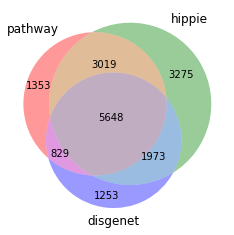

In [135]:
pathway_proteins = protein_pathway_nodes[protein_pathway_nodes.node_type == "gene_protein"].node_id.astype("int").values
hippie_proteins = hippie_node_data.node_id.values
gda_proteins = gda_node_data[gda_node_data.node_type == "gene_protein"].node_id.values

quick_venn([pathway_proteins,hippie_proteins,gda_proteins],["pathway","hippie","disgenet"])

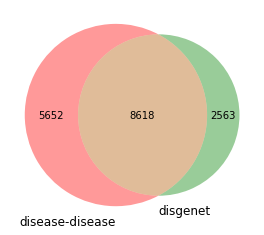

In [136]:
enfermedades_dd = disease_layer_nodes.node_id.values
enfermedades_gda = gda_disease_data.node_id.values

quick_venn([enfermedades_dd,enfermedades_gda],["disease-disease","disgenet"])

# Armo dataframes de atributos

## Disease attributes

In [137]:
def collapse_descriptions(description_list):
    unique = list(set(description_list))
    try:
        as_text = " ".join(unique)
    except:
        as_text = unique[0]
    return as_text

In [54]:
umls_data = pd.read_csv(data_external+"umls_data/umls_definitions.csv")

In [141]:
disgenet_disease_attr = pd.read_csv(data_external+"disease_mappings_to_attributes.tsv",sep="\t")
prime_disease_attr = pd.read_csv(data_external+"primekg_disease_features.csv")

disease_attributes = merged_nodes[(merged_nodes.node_type == "disease")].reset_index(drop=True)
disease_ids = disease_attributes.node_id.values
disease_prime_node_index = disease_layer_nodes.prime_node_index.dropna().astype("int").values

disgenet_disease_attr = disgenet_disease_attr.set_index("diseaseId").loc[disgenet_disease_attr.set_index("diseaseId").index.intersection(disease_ids)]
prime_disease_attr = prime_disease_attr.set_index("node_index").loc[disease_prime_node_index]

disease_attributes = pd.merge(disease_attributes,disease_mappings[["diseaseId","mondo_id"]].astype("string"), left_on="node_id",right_on="diseaseId",how="left").drop(columns="diseaseId")
disease_attributes = pd.merge(disease_attributes,prime_disease_attr[["mondo_id","mondo_name","mondo_definition","umls_description","orphanet_definition"]].astype("string"), left_on="mondo_id",right_on="mondo_id",how="left").drop_duplicates()

collapsed = disease_attributes[["node_id","mondo_definition","umls_description","orphanet_definition"]].groupby("node_id").agg(tuple).applymap(list).reset_index()
collapsed[["mondo_definition","umls_description","orphanet_definition"]] = collapsed[["mondo_definition","umls_description","orphanet_definition"]].applymap(collapse_descriptions)

disease_attributes = disease_attributes.drop_duplicates(subset="node_id")
disease_attributes = disease_attributes.drop(columns=["mondo_definition","umls_description","orphanet_definition"])
disease_attributes = pd.merge(disease_attributes,collapsed,left_on="node_id",right_on="node_id")
disease_attributes[["mondo_definition","umls_description","orphanet_definition"]] = collapsed[["mondo_definition","umls_description","orphanet_definition"]]

disease_attributes = pd.merge(disease_attributes,disgenet_disease_attr[["type","diseaseClassMSH","diseaseClassNameMSH"]],left_on="node_id",right_index=True, how="left").rename(columns={"type":"disgenet_type"})
disease_attributes = disease_attributes[["node_index","node_id","node_name","disgenet_type","mondo_id","mondo_name","mondo_definition","umls_description","orphanet_definition","diseaseClassMSH","diseaseClassNameMSH","node_source"]]

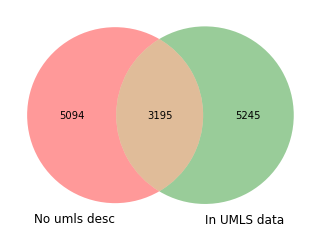

In [169]:
s1 = set(disease_attributes[disease_attributes.umls_description.isna()].node_id.values)
s2 = set(umls_data.CUI.values)

quick_venn([s1,s2],["No umls desc","In UMLS data"])

In [144]:
no_umls = disease_attributes[disease_attributes.umls_description.isna()]
mapeables = umls_data[umls_data.CUI.isin(no_umls.node_id.values)]
no_umls = no_umls.drop(columns="umls_description")
recovered_umls = pd.merge(no_umls,mapeables[["CUI","value"]], left_on="node_id",right_on="CUI",how="left").rename(columns={"value":"umls_description"}).drop(columns=["CUI"])
recovered_umls

,node_index,node_id,node_name,disgenet_type,mondo_id,mondo_name,mondo_definition,orphanet_definition,diseaseClassMSH,diseaseClassNameMSH,node_source,umls_description
0,18430,C0000737,Abdominal Pain,phenotype,<NA>,<NA>,<NA>,<NA>,C23,"Pathological Conditions, Signs and Symptoms",disgenet,"Sensation of discomfort, distress, or agony in..."
1,18434,C0000772,Multiple congenital anomalies,group,<NA>,<NA>,<NA>,<NA>,C16,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet,The presence of multiple congenital malformati...
2,18435,C0000786,Spontaneous abortion,phenotype,<NA>,<NA>,<NA>,<NA>,C13,Female Urogenital Diseases and Pregnancy Compl...,disgenet,Expulsion of the product of FERTILIZATION befo...
3,18438,C0000822,"Abortion, Tubal",phenotype,<NA>,<NA>,<NA>,<NA>,C13,Female Urogenital Diseases and Pregnancy Compl...,disgenet,NaN
4,18462,C0001338,Herpetic Acute Necrotizing Encephalitis,disease,<NA>,<NA>,<NA>,<NA>,C01;C10,Infections; Nervous System Diseases,disgenet,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8284,34191,C4755301,Idiopathic eosinophilic myositis,disease,16610,idiopathic eosinophilic myositis,<NA>,A rare idiopathic inflammatory myopathy charac...,C16;C05;C10,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet,A rare skeletal muscle disease with characteri...
8285,34192,C4755302,Focal palmoplantar keratoderma with joint kera...,disease,18252,focal palmoplantar keratoderma with joint kera...,<NA>,Focal palmoplantar keratoderma with joint kera...,NaN,NaN,disgenet,A rare genetic isolated palmoplantar keratoder...
8286,34193,C4755308,Familial cervical artery dissection,disease,18212,familial cervical artery dissection,An instance of cervical artery dissection that...,"Familial cervical artery dissection is a rare,...",NaN,NaN,disgenet,A rare genetic neurological disorder with char...
8287,34194,C4755309,Diffuse palmoplantar keratoderma with painful ...,disease,18250,diffuse palmoplantar keratoderma with painful ...,<NA>,Diffuse palmoplantar keratoderma with painful ...,C16;C17,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet,A rare genetic isolated palmoplantar keratoder...


In [170]:
has_umls = disease_attributes[~disease_attributes.umls_description.isna()]

In [174]:
disease_attributes

,node_index,node_id,node_name,disgenet_type,mondo_id,mondo_name,mondo_definition,umls_description,orphanet_definition,diseaseClassMSH,diseaseClassNameMSH,node_source
0,18430,C0000737,Abdominal Pain,phenotype,<NA>,<NA>,<NA>,<NA>,<NA>,C23,"Pathological Conditions, Signs and Symptoms",disgenet
1,18431,C0000744,Abetalipoproteinemia,disease,8692,abetalipoproteinemia,Abetalipoproteinemia/ homozygous familial hypo...,An autosomal dominant disorder of lipid metabo...,"A severe, familial hypobetalipoproteinemia cha...",C16;C18,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet
2,18432,C0000768,Congenital Abnormality,group,839,congenital abnormality,"Any abnormality, anatomical or biochemical, ev...",Any abnormality either hereditary or due an in...,<NA>,C16,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet
3,18433,C0000771,"Abnormalities, Drug-Induced",group,16677,toxic or drug-related embryofetopathy,Congenital abnormalities caused by medicinal s...,Congenital abnormalities caused by medicinal s...,<NA>,C16,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet
4,18434,C0000772,Multiple congenital anomalies,group,<NA>,<NA>,<NA>,<NA>,<NA>,C16,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet
...,...,...,...,...,...,...,...,...,...,...,...,...
15761,34191,C4755301,Idiopathic eosinophilic myositis,disease,16610,idiopathic eosinophilic myositis,<NA>,<NA>,A rare idiopathic inflammatory myopathy charac...,C16;C05;C10,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet
15762,34192,C4755302,Focal palmoplantar keratoderma with joint kera...,disease,18252,focal palmoplantar keratoderma with joint kera...,<NA>,<NA>,Focal palmoplantar keratoderma with joint kera...,NaN,NaN,disgenet
15763,34193,C4755308,Familial cervical artery dissection,disease,18212,familial cervical artery dissection,An instance of cervical artery dissection that...,<NA>,"Familial cervical artery dissection is a rare,...",NaN,NaN,disgenet
15764,34194,C4755309,Diffuse palmoplantar keratoderma with painful ...,disease,18250,diffuse palmoplantar keratoderma with painful ...,<NA>,<NA>,Diffuse palmoplantar keratoderma with painful ...,C16;C17,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet


In [192]:
has_umls = disease_attributes[~disease_attributes.umls_description.isna()]
disease_attributes = pd.concat([has_umls,recovered_umls])

Nan counts para descripciones, según fuente:

False    11145
True      4621
Name: mondo_definition, dtype: int64
True     10707
False     5059
Name: orphanet_definition, dtype: int64
False    10672
True      5094
Name: umls_description, dtype: int64


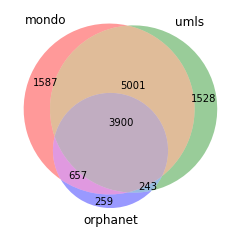

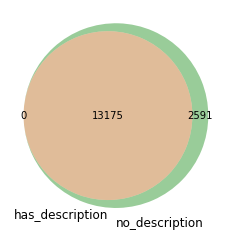

In [193]:
print("Nan counts para descripciones, según fuente:\n")
print(disease_attributes.mondo_definition.isna().value_counts())
print(disease_attributes.orphanet_definition.isna().value_counts())
print(disease_attributes.umls_description.isna().value_counts())

all_cuis = set(disease_attributes.node_id.values)
mondo = set(disease_attributes[~disease_attributes.mondo_definition.isna()].node_id.values)
umls = set(disease_attributes[~disease_attributes.umls_description.isna()].node_id.values)
orphanet = set(disease_attributes[~disease_attributes.orphanet_definition.isna()].node_id.values)


quick_venn([mondo,umls,orphanet],["mondo","umls","orphanet"])
quick_venn([(mondo|umls|orphanet), all_cuis],["has_description","no_description"])

In [64]:
# disease_attributes.to_csv(data_interim+"grafo_alternativo_disease_attributes.csv", index=False)

## Gene attributes

In [65]:
gene_attributes = disgenet_edges[["geneId","geneSymbol","DSI","DPI"]].rename(columns={"geneId":"node_id","geneSymbol":"node_name"}).drop_duplicates()
gene_attributes = pd.merge(gene_attributes,merged_nodes.loc[merged_nodes.node_type == "gene_protein",["node_index","node_id"]].astype({"node_id":"int"}), left_on="node_id",right_on="node_id",how="left")
gene_attributes = gene_attributes[["node_index","node_id","node_name","DSI","DPI"]].sort_values(by="node_index").reset_index(drop=True)
gene_attributes

,node_index,node_id,node_name,DSI,DPI
0,0,1,A1BG,0.700,0.538
1,1,10,NAT2,0.451,0.885
2,2,100,ADA,0.440,0.885
3,3,1000,CDH2,0.535,0.731
4,4,10000,AKT3,0.512,0.808
...,...,...,...,...,...
9698,18421,999,CDH1,0.401,0.808
9699,18422,9990,SLC12A6,0.603,0.500
9700,18424,9992,KCNE2,0.628,0.423
9701,18425,9993,DGCR2,0.623,0.731


In [66]:
#gene_attributes.to_csv(data_interim+"grafo_alternativo_gene_attributes.csv",index=False)

## Edge attributes

In [67]:
gda_edge_attributes = pd.merge(disgenet_edges,merged_nodes[["node_index","node_id"]],left_on="diseaseId",right_on="node_id",how="left").drop(columns="node_id").rename(columns={"node_index":"disease_node_index"})
gda_edge_attributes = pd.merge(gda_edge_attributes.astype({"geneId":"string"}),merged_nodes[["node_index","node_id"]], left_on="geneId",right_on="node_id").drop(columns="node_id").rename(columns={"node_index":"gene_node_index"})
gda_edge_attributes = gda_edge_attributes[["geneId","geneSymbol","gene_node_index","diseaseId","diseaseName","disease_node_index","score","EI","YearInitial","YearFinal","NofPmids","NofSnps","source"]]

gda_edge_attributes

,geneId,geneSymbol,gene_node_index,diseaseId,diseaseName,disease_node_index,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0,C0019209,Hepatomegaly,19599,0.30,1.000,2017.0,2017.0,1,0,CTD_human
1,1,A1BG,0,C0036341,Schizophrenia,20754,0.30,1.000,2015.0,2015.0,1,0,CTD_human
2,2,A2M,4065,C0002395,Alzheimer's Disease,18524,0.50,0.769,1998.0,2018.0,3,0,CTD_human
3,2,A2M,4065,C0007102,Malignant tumor of colon,18816,0.31,1.000,2004.0,2019.0,1,0,CTD_human
4,2,A2M,4065,C0009375,Colonic Neoplasms,18975,0.30,1.000,2004.0,2004.0,1,0,CTD_human
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84033,109580095,HBB-LCR,1131,C0002875,Cooley's anemia,18548,0.30,NaN,NaN,NaN,0,0,CTD_human
84034,109580095,HBB-LCR,1131,C0005283,beta Thalassemia,18716,0.30,NaN,NaN,NaN,0,0,CTD_human
84035,109580095,HBB-LCR,1131,C0019025,Hemoglobin F Disease,19564,0.30,NaN,NaN,NaN,0,0,CTD_human
84036,109580095,HBB-LCR,1131,C0085578,Thalassemia Minor,21292,0.30,NaN,NaN,NaN,0,0,CTD_human


In [68]:
#gda_edge_attributes.to_csv(data_interim+"grafo_alternativo_gda_edge_attributes.csv",index=False)